In [4]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

class missile_interception_3d(gym.Env):
    def __init__(self):
        # 1. Define Action Space (The Joystick: Left/Right, Up/Down)
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(2, ), dtype=np.float32)
        
        # 2. Define Observation Space (20D ego-frame version)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(20,), dtype=np.float32)

        self.np_random = np.random.RandomState()
        
        # 3. Time Settings
        self.dt_act = 0.1             
        self.n_substeps = 10          
        self.dt_sim = self.dt_act / self.n_substeps 
        self.t_max = 650.0            

        # 4. Physical Limits
        self.a_max = 350.0   # Max G-force (m/s^2) ~35G
        self.da_max = 2500.0 # Jerk Limit (m/s^3)
        self.tau = 0.05      # Airframe Lag
        self.g = 9.81        
        self.collision_radius = 150.0  
        self.max_distance = 4_000_000.0 

        self.p_easy = 1.0                   
        self.range_min = 70_000.0           
        self.range_easy_max = 200_000.0     
        self.range_hard_max = 1_000_000.0   

        self.targetbox_x_min = -15000
        self.targetbox_x_max = 15000
        self.targetbox_y_min = -15000
        self.targetbox_y_max = 15000

        # ----------------------------
        # Potential-based shaping (ZEM_perp)
        # IMPORTANT: gamma_shape MUST match PPO's gamma
        # ----------------------------
        self.gamma_shape = 0.9999      # set to your PPO gamma
        self.w_zem = 1.0             # shaping weight
        self.zem_scale = 50_000.0    # meters; tunes magnitude of phi
        self.tgo_max = 15.0          # seconds; clamp lookahead when closing
        self.tgo_fixed = 3.0         # seconds; lookahead when NOT closing
        self.vc_min = 1.0            # m/s; treat <= this as "not closing"

    def generate_enemy_missile(self):
        if self.np_random.rand() < self.p_easy:
            self.range_max_used = self.range_easy_max
        else:
            self.range_max_used = self.range_hard_max

        range_min = self.range_min
        self.attack_target_x = self.np_random.uniform(self.targetbox_x_min, self.targetbox_x_max)
        self.attack_target_y = self.np_random.uniform(self.targetbox_y_min, self.targetbox_y_max)
        self.enemy_launch_angle = self.np_random.uniform(0, 2 * np.pi)
        self.enemy_theta = self.np_random.uniform(0.523599, 1.0472) 

        self.range_max_used = max(self.range_max_used, range_min + 1.0)
        lower_limit = np.sqrt((range_min * self.g) / np.sin(2 * self.enemy_theta))
        upper_limit = np.sqrt((self.range_max_used * self.g) / np.sin(2 * self.enemy_theta))
        self.enemy_initial_velocity = self.np_random.uniform(lower_limit, upper_limit)

        ground_range = (
            self.enemy_initial_velocity * np.cos(self.enemy_theta)
            * (2 * self.enemy_initial_velocity * np.sin(self.enemy_theta) / self.g)
        )

        self.enemy_launch_x = self.attack_target_x + ground_range * np.cos(self.enemy_launch_angle)
        self.enemy_launch_y = self.attack_target_y + ground_range * np.sin(self.enemy_launch_angle)
        self.enemy_z = 0
        self.enemy_x = self.enemy_launch_x
        self.enemy_y = self.enemy_launch_y
        self.enemy_pos = np.array([self.enemy_x, self.enemy_y, self.enemy_z], dtype=np.float32)
        self.enemy_azimuth = (self.enemy_launch_angle + np.pi) % (2 * np.pi)

    def generate_defense_missile(self):
        self.defense_launch_x = self.np_random.uniform(self.targetbox_x_min, self.targetbox_x_max)
        self.defense_launch_y = self.np_random.uniform(self.targetbox_y_min, self.targetbox_y_max)

        dx = self.enemy_launch_x - self.defense_launch_x
        dy = self.enemy_launch_y - self.defense_launch_y
        az_nominal = np.arctan2(dy, dx)

        # --- Misalignment (domain randomization of initial heading) ---
        # Mixture: most episodes small error, some episodes large az error
        p_misaligned = 0.35  # 35% "hard" starts
        if self.np_random.rand() < p_misaligned:
            # Hard: big azimuth error → strong RIGHT required
            az_noise = self.np_random.uniform(-np.deg2rad(60.0), np.deg2rad(60.0))
        else:
            # Easy: small azimuth error → gentle correction
            az_noise = self.np_random.uniform(-np.deg2rad(10.0), np.deg2rad(10.0))

        self.defense_azimuth = az_nominal + az_noise

        # Elevation noise: avoid always same vertical plane
        theta_nominal = 0.785398  # ~45 deg
        theta_noise_deg = 10.0
        theta_noise = self.np_random.uniform(
            -np.deg2rad(theta_noise_deg),
            +np.deg2rad(theta_noise_deg),
        )
        self.defense_theta = float(np.clip(theta_nominal + theta_noise,
                                           np.deg2rad(10.0),
                                           np.deg2rad(80.0)))
        # ---------------------------------------------------------------

        base_velocity = 3000.0
        if hasattr(self, 'range_max_used'):
            velocity_scale = min(self.range_max_used / self.range_easy_max, 1.5)
            self.defense_initial_velocity = base_velocity * velocity_scale
        else:
            self.defense_initial_velocity = base_velocity

        self.defense_x = self.defense_launch_x
        self.defense_y = self.defense_launch_y
        self.defense_z = 0.0
        self.defense_pos = np.array([self.defense_x, self.defense_y, self.defense_z], dtype=np.float32)

        self.defense_ax = 0.0
        self.defense_ay = 0.0
        self.defense_az = 0.0
    
    def _smoothstep(self, x: float) -> float:
        """Smooth ramp 0->1 with zero slope at ends, clamps outside [0,1]"""
        x = float(np.clip(x, 0.0, 1.0))
        return x * x * (3.0 - 2.0 * x)
    
    def calculate_pronav(self):
        eps = 1e-9

        # Relative geometry (use float64 for stability)
        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        v = self.defense_vel.astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)

        R = float(np.linalg.norm(r)) + eps
        V = float(np.linalg.norm(v)) + eps

        rhat = r / R
        vhat = v / V

        # Heading error alpha = angle between velocity direction and LOS direction
        cosang = float(np.clip(np.dot(vhat, rhat), -1.0, 1.0))
        alpha = float(np.arccos(cosang))  # radians

        # LOS angular rate omega (world frame)
        omega = np.cross(r, vrel) / (float(np.dot(r, r)) + eps)
        omega_mag = float(np.linalg.norm(omega))

        # Closing speed (positive => closing)
        vc = -float(np.dot(r, vrel)) / R

        # --- PN term ---
        N = 3.0
        a_pn = N * vc * np.cross(omega, rhat)  # lateral accel in world frame

        # --- Acquisition term (turn-to-LOS) ---
        # Perpendicular component of LOS relative to forward direction
        rhat_perp = rhat - float(np.dot(rhat, vhat)) * vhat
        nperp = float(np.linalg.norm(rhat_perp))

        if nperp < 1e-8:
            a_acq = np.zeros(3, dtype=np.float64)
        else:
            rhat_perp /= nperp  # unit sideways "turn toward LOS" direction

            # Curvature-based magnitude: ~k * V^2 / R, saturate later via a_max
            k_acq = 5.0  # try 3.0–8.0
            a_acq = k_acq * (V * V / R) * rhat_perp

        # --- Blend weight w: 0 => pure PN, 1 => pure acquisition ---

        # Alpha-based weight (dominant)
        alpha_on   = np.deg2rad(20.0)   # start blending earlier
        alpha_full = np.deg2rad(55.0)

        x_alpha = (alpha - alpha_on) / (alpha_full - alpha_on + eps)
        w_alpha = self._smoothstep(x_alpha)

        # Omega-based modifier (only boosts acquisition when PN is sleepy)
        omega_full = 0.00
        omega_on   = 0.05   # <-- key: less brittle than 0.02

        x_omega = (omega_on - omega_mag) / (omega_on - omega_full + eps)
        w_omega = self._smoothstep(x_omega)

        # Robust combine: alpha dominates; omega can't fully shut it off
        w = w_alpha * (0.25 + 0.75 * w_omega)

        # Optional: if not closing, force strong acquisition
        if vc <= 0.0:
            w = max(w, 0.9)

        a_ideal = (1.0 - w) * a_pn + w * a_acq

        # Project into your lateral control basis (right/up) and normalize by a_max
        # Note: Environment now handles gravity compensation internally,
        # so ProNav outputs desired NET lateral accel (same semantics as PPO)
        forward, right, up = self._compute_lateral_basis(self.defense_vel)
        a_right = float(np.dot(a_ideal, right))
        a_up    = float(np.dot(a_ideal, up))

        action = np.array([a_right / self.a_max, a_up / self.a_max], dtype=np.float32)
        return np.clip(action, -1.0, 1.0)
    
    def _rate_limit_norm(self, a_cmd, a_prev, da_max, dt):
        delta = a_cmd - a_prev
        max_delta = da_max * dt
        dnorm = float(np.linalg.norm(delta))
        if dnorm <= max_delta or dnorm < 1e-9:
            return a_cmd
        return a_prev + delta * (max_delta / dnorm)
    
    def _segment_sphere_intersect(self, r0, r1, r_hit):
        dr = r1 - r0
        dr_norm_sq = float(np.dot(dr, dr))
        if dr_norm_sq < 1e-12:
            return float(np.dot(r0, r0)) <= r_hit * r_hit
        s_star = -float(np.dot(r0, dr)) / dr_norm_sq
        s_star = max(0.0, min(1.0, s_star))
        r_closest = r0 + s_star * dr
        return float(np.dot(r_closest, r_closest)) <= r_hit * r_hit
    
    def _phi_zem_perp(self):
        """
        Potential for potential-based shaping:
          Phi(s) = - ||ZEM_perp|| / zem_scale

        Returns:
          phi, zem_perp_norm, Vc, tgo
        """
        eps = 1e-9

        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)

        R = float(np.linalg.norm(r)) + eps
        rhat = r / R

        # Closing speed (positive = closing)
        Vc = -float(np.dot(rhat, vrel))

        if Vc > self.vc_min:
            tgo = R / max(Vc, eps)
            tgo = float(np.clip(tgo, 0.0, self.tgo_max))
        else:
            tgo = float(self.tgo_fixed)

        zem = r + vrel * tgo
        zem_perp = zem - float(np.dot(zem, rhat)) * rhat
        zem_perp_norm = float(np.linalg.norm(zem_perp))

        phi = -zem_perp_norm / (float(self.zem_scale) + eps)
        return float(phi), zem_perp_norm, float(Vc), tgo
    
    
    def _get_obs(self):
        eps = 1e-9

        # World-frame relative state
        r_world = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel_world = (self.enemy_vel - self.defense_vel).astype(np.float64)

        # Local basis from defense velocity (world frame unit vectors)
        forward, right, up = self._compute_lateral_basis(self.defense_vel)

        # ===============================
        # 1) Ego-frame (body-frame) r and vrel
        # ===============================
        r_body = np.array([
            float(np.dot(r_world, forward)),
            float(np.dot(r_world, right)),
            float(np.dot(r_world, up)),
        ], dtype=np.float64)

        vrel_body = np.array([
            float(np.dot(vrel_world, forward)),
            float(np.dot(vrel_world, right)),
            float(np.dot(vrel_world, up)),
        ], dtype=np.float64)

        # Normalize r_body / vrel_body (keep your original scaling)
        pos_scale = float(self.range_hard_max)   # 1_000_000
        vel_scale = 4000.0

        r_body_n = (r_body / (pos_scale + eps)).astype(np.float32)
        vrel_body_n = (vrel_body / (vel_scale + eps)).astype(np.float32)

        # ===============================
        # 2) Actuator state in the same action frame
        # ===============================
        a_lat = np.array([
            float(np.dot(self.a_actual, right)) / (self.a_max + eps),
            float(np.dot(self.a_actual, up)) / (self.a_max + eps),
        ], dtype=np.float32)

        # NEW: hidden actuator state that affects transitions
        a_cmd_prev_lat = np.array([
            float(np.dot(self.a_cmd_prev, right)) / (self.a_max + eps),
            float(np.dot(self.a_cmd_prev, up)) / (self.a_max + eps),
        ], dtype=np.float32)

        # ===============================
        # 3) Scalar helpers (kept)
        # ===============================
        dist = float(np.linalg.norm(r_world)) + 1e-6
        v_close = -float(np.dot(r_world, vrel_world)) / dist  # positive when closing

        dist_n = np.float32(np.clip(dist / 1_000_000.0, 0.0, 4.0))
        vclose_n = np.float32(np.clip(v_close / 3000.0, -2.0, 2.0))
        dist_vclose_feat = np.array([dist_n, vclose_n], dtype=np.float32)

        # Defense own vertical state (keep for ground constraint)
        def_z_n = np.float32(np.clip(self.defense_pos[2] / 100_000.0, -1.0, 2.0))
        def_vz_n = np.float32(np.clip(self.defense_vel[2] / 3000.0, -2.0, 2.0))
        def_state_feat = np.array([def_z_n, def_vz_n], dtype=np.float32)

        # ===============================
        # 4) Keep your geometry features (consistent with ego-frame)
        # ===============================
        dist_body = float(np.linalg.norm(r_body)) + 1e-6

        # LOS lateral projections in body frame
        los_right = float(r_body[1] / dist_body)
        los_up    = float(r_body[2] / dist_body)

        # LOS rate omega in body frame: omega = (r x vrel)/||r||^2
        dist2_body = float(np.dot(r_body, r_body)) + eps
        omega_body = np.cross(r_body, vrel_body) / dist2_body

        omega_right = float(omega_body[1])
        omega_up    = float(omega_body[2])

        omega_scale = 2.0
        omega_right_n = float(np.clip(omega_right / omega_scale, -2.0, 2.0))
        omega_up_n    = float(np.clip(omega_up / omega_scale, -2.0, 2.0))

        geom_feat = np.array([los_right, los_up, omega_right_n, omega_up_n], dtype=np.float32)

        # ===============================
        # 5) NEW: kinematics garnish
        # ===============================
        V_def = float(np.linalg.norm(self.defense_vel))
        V_def_n = np.float32(np.clip(V_def / 3000.0, 0.0, 3.0))  # scale: 3000 m/s baseline
        forward_z = np.float32(float(forward[2]))               # dot(forward, world_up) since world_up=[0,0,1]

        kin_feat = np.array([V_def_n, forward_z], dtype=np.float32)

        # Final obs (20D)
        obs = np.concatenate(
            [r_body_n, vrel_body_n, a_lat, a_cmd_prev_lat, dist_vclose_feat, def_state_feat, geom_feat, kin_feat],
            axis=0
        ).astype(np.float32)

        # Optional sanity check while iterating
        # assert obs.shape == (20,), obs.shape

        return obs

    def _compute_lateral_basis(self, velocity):
        """
        Horizon-stable basis:
          forward = along velocity
          right   = world_up x forward  (horizontal right)
          up      = forward x right     (completes orthonormal frame)
        This keeps 'up' as close to world-up as possible and avoids weird twisting.
        """
        speed = float(np.linalg.norm(velocity))
        if speed < 1.0:
            forward = np.array([1.0, 0.0, 0.0], dtype=np.float32)
        else:
            forward = (velocity / speed).astype(np.float32)

        world_up = np.array([0.0, 0.0, 1.0], dtype=np.float32)

        # right = world_up x forward
        right_raw = np.cross(world_up, forward)
        rnorm = float(np.linalg.norm(right_raw))

        # If forward is near world_up, right_raw ~ 0. Pick a consistent fallback.
        if rnorm < 1e-6:
            # Choose a fixed "north" axis in world XY and build right from that
            # This prevents random spinning when vertical.
            north = np.array([1.0, 0.0, 0.0], dtype=np.float32)
            right_raw = np.cross(north, forward)
            rnorm = float(np.linalg.norm(right_raw))
            if rnorm < 1e-6:
                north = np.array([0.0, 1.0, 0.0], dtype=np.float32)
                right_raw = np.cross(north, forward)
                rnorm = float(np.linalg.norm(right_raw))

        right = (right_raw / (rnorm + 1e-9)).astype(np.float32)

        # up = forward x right (not right x forward)
        up_raw = np.cross(forward, right)
        up = (up_raw / (float(np.linalg.norm(up_raw)) + 1e-9)).astype(np.float32)

        return forward, right, up

    def step(self, action):
        if getattr(self, "done", False):
            return self._get_obs(), 0.0, True, False, {"event": "called_step_after_done", "dist": self.relative_distances[-1]}
        
        action = np.clip(action, -1.0, 1.0).astype(np.float32)
        mag = float(np.linalg.norm(action))
        if mag > 1.0:
            action = action / mag
            mag = 1.0
        
        # Update episode trackers
        self.ep_max_action_mag = max(self.ep_max_action_mag, float(mag))
        self.ep_max_accel = max(self.ep_max_accel, float(np.linalg.norm(self.a_actual)))

        dist_before = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
        
        # --- Shaping: compute phi BEFORE transition ---
        phi_before, zem_perp_before, Vc_before, tgo_before = self._phi_zem_perp()
        terminated = False
        truncated = False
        event = "running"
        
        for _ in range(self.n_substeps):
            dt = self.dt_sim
            enemy_pos_old = self.enemy_pos.copy()
            defense_pos_old = self.defense_pos.copy()
            
            forward, right, up = self._compute_lateral_basis(self.defense_vel)
            
            # Agent command = desired NET lateral accel (world frame)
            a_net_lat_cmd = (action[0] * self.a_max * right) + (action[1] * self.a_max * up)
            
            # Gravity (world frame)
            g_vec = np.array([0.0, 0.0, -self.g], dtype=np.float32)
            
            # Lateral component of gravity in the right/up plane
            g_lat = (np.dot(g_vec, right) * right) + (np.dot(g_vec, up) * up)
            
            # Fins must cancel lateral gravity to achieve commanded NET lateral accel
            a_fins_cmd = a_net_lat_cmd - g_lat
            
            # Apply rate limit + lag to fins acceleration
            self.a_cmd_prev = self._rate_limit_norm(a_fins_cmd, self.a_cmd_prev, self.da_max, dt)
            self.a_actual += (self.a_cmd_prev - self.a_actual) * (dt / self.tau)
            
            # Integrate translational dynamics
            self.defense_vel += (self.a_actual + g_vec) * dt
            self.defense_pos += self.defense_vel * dt
            self.defense_x, self.defense_y, self.defense_z = self.defense_pos
            
            # Enemy missile: pure ballistic (gravity only)
            self.enemy_vel += g_vec * dt
            self.enemy_pos += self.enemy_vel * dt
            self.enemy_x, self.enemy_y, self.enemy_z = self.enemy_pos
            self.t += dt
            
            r0 = enemy_pos_old - defense_pos_old
            r1 = self.enemy_pos - self.defense_pos
            if self._segment_sphere_intersect(r0, r1, self.collision_radius):
                self.success = True
                terminated = True
                self.done = True
                event = "hit"
                self.time_to_hit = float(self.t)
                self.terminal_event = "hit"
                break
            
            dist = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
            if dist > self.max_distance:
                truncated = True
                self.done = True
                event = "diverged"
                self.terminal_event = "diverged"
                break
            if self.defense_pos[2] < 0:
                terminated = True
                self.done = True
                event = "defense_ground"
                self.terminal_event = "defense_ground"
                break
            if self.enemy_pos[2] < 0:
                terminated = True
                self.done = True
                event = "enemy_ground"
                self.terminal_event = "enemy_ground"
                break
            if self.t >= self.t_max:
                truncated = True
                self.done = True
                event = "timeout"
                self.terminal_event = "timeout"
                break

        self.enemy_path.append(self.enemy_pos.copy())
        self.defense_path.append(self.defense_pos.copy())
        self.relative_distances.append(float(np.linalg.norm(self.enemy_pos - self.defense_pos)))
        self.times.append(self.t)
        
        obs = self._get_obs()
        dist_after = float(np.linalg.norm(self.enemy_pos - self.defense_pos))
        self.min_dist = min(getattr(self, "min_dist", float("inf")), dist_after)
        self.ep_min_dist = min(self.ep_min_dist, float(dist_after))
        
        # Reward calculation (same as before)
        r_progress = (dist_before - dist_after) / 100.0
        v_scale = 1500.0
        r = (self.enemy_pos - self.defense_pos).astype(np.float64)
        vrel = (self.enemy_vel - self.defense_vel).astype(np.float64)
        d = float(np.linalg.norm(r)) + 1e-9
        rhat = r / d
        d_dot = float(np.dot(rhat, vrel))
        r_close = np.tanh((-d_dot) / v_scale)
        
        # --- Shaping: compute phi AFTER transition ---
        if terminated or truncated:
            # standard trick for episodic shaping: set terminal potential to 0
            phi_after = 0.0
            zem_perp_after = None
            Vc_after = None
            tgo_after = None
        else:
            phi_after, zem_perp_after, Vc_after, tgo_after = self._phi_zem_perp()

        r_zem = self.w_zem * (self.gamma_shape * phi_after - phi_before)
        
        # Accumulate shaping rewards for debugging
        self.sum_r_progress += float(r_progress)
        self.sum_r_close += float(r_close)
        self.sum_r_zem += float(r_zem)
        
        # Reward breakdown (named components)
        step_penalty = -0.001
        terminal_bonus = 0.0
        terminal_penalty = 0.0
        
        if self.success:
            terminal_bonus = 10000.0
        elif terminated or truncated:
            if event == "defense_ground":
                terminal_penalty += 10000.0
            terminal_penalty += min(2000.0, self.ep_min_dist / 50.0)
        
        reward = (1.0 * r_progress) + (0.1 * r_close) + step_penalty + terminal_bonus - terminal_penalty + r_zem
        
        info = {
            "event": event,
            "t": float(self.t),
            
            # reward pieces (training-related)
            "reward_terms": {
                "r_progress": float(r_progress),
                "r_close": float(r_close),
                "step_penalty": float(step_penalty),
                "terminal_bonus": float(terminal_bonus),
                "terminal_penalty": float(-terminal_penalty),  # negative contribution
                "r_zem": float(r_zem),
            },
            "reward": float(reward),
            
            # ZEM shaping debug info
            "zem_debug": {
                "phi_before": float(phi_before),
                "phi_after": float(phi_after),
                "zem_perp_before": float(zem_perp_before),
                "zem_perp_after": None if zem_perp_after is None else float(zem_perp_after),
                "Vc_before": float(Vc_before),
                "Vc_after": None if Vc_after is None else float(Vc_after),
                "tgo_before": float(tgo_before),
                "tgo_after": None if tgo_after is None else float(tgo_after),
            },
            
            # eval snapshots (NOT the full episode metrics yet)
            "eval_step": {
                "dist": float(dist_after),
                "action_mag": float(mag),
                "accel_norm": float(np.linalg.norm(self.a_actual)),
            },
        }
        
        # --- Episode metrics (only at termination, for CSV logger) ---
        # Put these in info so callback can read them BEFORE VecEnv resets
        if terminated or truncated:
            info["event"] = self.terminal_event
            info["final_dist"] = float(dist_after)
            info["min_dist"] = float(self.ep_min_dist)
            info["sum_r_progress"] = float(self.sum_r_progress)
            info["sum_r_close"] = float(self.sum_r_close)
            info["sum_r_zem"] = float(self.sum_r_zem)
            info["max_action_mag"] = float(self.ep_max_action_mag)
            info["max_accel_norm"] = float(self.ep_max_accel)
            info["time_to_hit"] = float(self.time_to_hit) if self.time_to_hit is not None else np.nan
        
        
        return obs, reward, terminated, truncated, info


    def _snapshot(self):
        """Copy everything that affects future transitions + trackers used by reward."""
        return {
            "t": float(self.t),
            "enemy_pos": self.enemy_pos.copy(),
            "enemy_vel": self.enemy_vel.copy(),
            "defense_pos": self.defense_pos.copy(),
            "defense_vel": self.defense_vel.copy(),
            "a_actual": self.a_actual.copy(),
            "a_cmd_prev": self.a_cmd_prev.copy(),
            "done": bool(getattr(self, "done", False)),
            "success": bool(getattr(self, "success", False)),

            # reward-critical trackers
            "min_dist": float(getattr(self, "min_dist", float("inf"))),
            "ep_min_dist": float(getattr(self, "ep_min_dist", float("inf"))),

            # episode trackers (not strictly needed for the local test but cheap)
            "ep_max_action_mag": float(getattr(self, "ep_max_action_mag", 0.0)),
            "ep_max_accel": float(getattr(self, "ep_max_accel", 0.0)),
            "time_to_hit": getattr(self, "time_to_hit", None),
            "terminal_event": getattr(self, "terminal_event", "running"),

            # log lengths (so restore can truncate)
            "enemy_path_len": len(getattr(self, "enemy_path", [])),
            "defense_path_len": len(getattr(self, "defense_path", [])),
            "relative_distances_len": len(getattr(self, "relative_distances", [])),
            "times_len": len(getattr(self, "times", [])),
        }

    def _restore(self, snap):
        """Restore environment state from snapshot."""
        self.t = float(snap["t"])
        self.enemy_pos = snap["enemy_pos"].copy()
        self.enemy_vel = snap["enemy_vel"].copy()
        self.defense_pos = snap["defense_pos"].copy()
        self.defense_vel = snap["defense_vel"].copy()
        self.a_actual = snap["a_actual"].copy()
        self.a_cmd_prev = snap["a_cmd_prev"].copy()
        self.done = bool(snap["done"])
        self.success = bool(snap["success"])

        self.min_dist = float(snap["min_dist"])
        self.ep_min_dist = float(snap["ep_min_dist"])

        self.ep_max_action_mag = float(snap["ep_max_action_mag"])
        self.ep_max_accel = float(snap["ep_max_accel"])
        self.time_to_hit = snap["time_to_hit"]
        self.terminal_event = snap["terminal_event"]

        # truncate logs (avoid memory blow + keep things consistent)
        if hasattr(self, "enemy_path"):
            self.enemy_path = self.enemy_path[: snap["enemy_path_len"]]
        if hasattr(self, "defense_path"):
            self.defense_path = self.defense_path[: snap["defense_path_len"]]
        if hasattr(self, "relative_distances"):
            self.relative_distances = self.relative_distances[: snap["relative_distances_len"]]
        if hasattr(self, "times"):
            self.times = self.times[: snap["times_len"]]


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None: self.np_random = np.random.RandomState(seed)
        self.done = False
        self.success = False
        self.t = 0.0
        self.generate_enemy_missile()
        self.generate_defense_missile()
        
        self.defense_vel = np.array([
            self.defense_initial_velocity * np.cos(self.defense_azimuth) * np.cos(self.defense_theta),
            self.defense_initial_velocity * np.sin(self.defense_azimuth) * np.cos(self.defense_theta),
            self.defense_initial_velocity * np.sin(self.defense_theta)
        ], dtype=np.float32)
        
        self.enemy_vel = np.array([
            self.enemy_initial_velocity * np.cos(self.enemy_azimuth) * np.cos(self.enemy_theta),
            self.enemy_initial_velocity * np.sin(self.enemy_azimuth) * np.cos(self.enemy_theta),
            self.enemy_initial_velocity * np.sin(self.enemy_theta)
        ], dtype=np.float32)
        
        self.a_actual = np.zeros(3, dtype=np.float32)
        self.a_cmd_prev = np.zeros(3, dtype=np.float32)
        self.defense_pos = np.array([self.defense_x, self.defense_y, self.defense_z], dtype=np.float32)
        self.enemy_pos = np.array([self.enemy_x, self.enemy_y, self.enemy_z], dtype=np.float32)
        self.enemy_path = [self.enemy_pos.copy()]
        self.defense_path = [self.defense_pos.copy()]
        self.relative_distances = [float(np.linalg.norm(self.enemy_pos - self.defense_pos))]
        self.times = [self.t]
        self.min_dist = float(self.relative_distances[-1])
        self.sum_r_progress = 0.0
        self.sum_r_close = 0.0
        self.sum_r_zem = 0.0
        
        # --- episode eval trackers (NOT used in reward) ---
        self.ep_min_dist = float("inf")
        self.ep_max_action_mag = 0.0
        self.ep_max_accel = 0.0          # optional: actual accel norm
        self.time_to_hit = None
        self.terminal_event = "running"
        
        return self._get_obs(), {}


# ==========================================
# EVALUATION FUNCTION (separate from training reward)
# ==========================================
def evaluate_policy(env, policy_fn, n_episodes=100, seed0=0):
    """
    Evaluate a policy and return episode-level metrics.
    This is separate from training reward - these metrics are what you actually care about.
    
    Args:
        env: missile_interception_3d environment instance
        policy_fn: Function that takes obs and returns action
        n_episodes: Number of episodes to evaluate
        seed0: Starting seed (episodes use seed0, seed0+1, ..., seed0+n_episodes-1)
    
    Returns:
        summary: Dict with aggregated metrics (hit_rate, min_dist stats, etc.)
        metrics: Dict with raw episode data
    """
    metrics = {
        "hits": 0,
        "ground_defense": 0,
        "ground_enemy": 0,
        "diverged": 0,
        "timeout": 0,
        "min_dist_list": [],
        "time_to_hit_list": [],
        "max_g_list": [],
    }

    for i in range(n_episodes):
        obs, _ = env.reset(seed=seed0 + i)
        done = False

        while not done:
            action = policy_fn(obs)  # your PPO policy OR env.calculate_pronav() baseline
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

        event = info["event"]
        metrics["min_dist_list"].append(env.ep_min_dist)
        metrics["max_g_list"].append(env.ep_max_action_mag)

        if event == "hit":
            metrics["hits"] += 1
            if env.time_to_hit is not None:
                metrics["time_to_hit_list"].append(env.time_to_hit)
        elif event == "defense_ground":
            metrics["ground_defense"] += 1
        elif event == "enemy_ground":
            metrics["ground_enemy"] += 1
        elif event == "diverged":
            metrics["diverged"] += 1
        elif event == "timeout":
            metrics["timeout"] += 1

    hit_rate = metrics["hits"] / n_episodes

    summary = {
        "hit_rate": hit_rate,
        "min_dist_mean": float(np.mean(metrics["min_dist_list"])),
        "min_dist_p50": float(np.median(metrics["min_dist_list"])),
        "min_dist_p10": float(np.percentile(metrics["min_dist_list"], 10)),
        "time_to_hit_mean": float(np.mean(metrics["time_to_hit_list"])) if metrics["time_to_hit_list"] else None,
        "max_g_mean": float(np.mean(metrics["max_g_list"])),
        "violations": {
            "defense_ground": metrics["ground_defense"],
            "enemy_ground": metrics["ground_enemy"],
            "diverged": metrics["diverged"],
            "timeout": metrics["timeout"],
        }
    }
    return summary, metrics




def run_baseline():
    env = missile_interception_3d()
    outcomes = []
    min_distances = []
    action_loads = [] # Track if we are saturating (maxing out fins)

    N_EPISODES = 50
    print(f"Running {N_EPISODES} episodes of Augmented ProNav...")

    for i in range(N_EPISODES):
        obs, _ = env.reset(seed=i)
        done = False
        ep_actions = []

        while not done:
            # 1. Ask ProNav for the move
            action = env.calculate_pronav()
            
            # 2. Track how hard it's pushing (0.0 to 1.0)
            mag = np.linalg.norm(action)
            ep_actions.append(mag)

            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        
        outcomes.append(info['event'])
        min_distances.append(info['min_dist'])
        avg_load = np.mean(ep_actions)
        action_loads.append(avg_load)

        print(f"Ep {i+1:02d} | Res: {info['event']:<14} | Min Dist: {info['min_dist']:.1f} m | Avg G-Load: {avg_load*100:.1f}%")

    # Final Stats
    hits = outcomes.count("hit")
    print("\n--- SUMMARY ---")
    print(f"Hit Rate: {hits}/{N_EPISODES} ({hits/N_EPISODES*100:.1f}%)")
    print(f"Average Miss Distance (Non-hits): {np.mean([d for d, e in zip(min_distances, outcomes) if e != 'hit']):.2f} m")
    print(f"Average G-Loading: {np.mean(action_loads)*100:.1f}% (If >90%, missile is physically too weak)")

if __name__ == "__main__":
    run_baseline()

Running 50 episodes of Augmented ProNav...
Ep 01 | Res: hit            | Min Dist: 133.0 m | Avg G-Load: 22.0%
Ep 02 | Res: hit            | Min Dist: 112.4 m | Avg G-Load: 44.3%
Ep 03 | Res: hit            | Min Dist: 113.3 m | Avg G-Load: 31.0%
Ep 04 | Res: hit            | Min Dist: 145.6 m | Avg G-Load: 9.2%
Ep 05 | Res: hit            | Min Dist: 141.9 m | Avg G-Load: 40.4%
Ep 06 | Res: hit            | Min Dist: 149.6 m | Avg G-Load: 22.0%
Ep 07 | Res: hit            | Min Dist: 122.9 m | Avg G-Load: 22.8%
Ep 08 | Res: hit            | Min Dist: 146.9 m | Avg G-Load: 18.7%
Ep 09 | Res: hit            | Min Dist: 131.2 m | Avg G-Load: 56.9%
Ep 10 | Res: hit            | Min Dist: 127.3 m | Avg G-Load: 29.2%
Ep 11 | Res: hit            | Min Dist: 148.1 m | Avg G-Load: 41.9%
Ep 12 | Res: hit            | Min Dist: 132.3 m | Avg G-Load: 24.5%
Ep 13 | Res: hit            | Min Dist: 139.7 m | Avg G-Load: 15.9%
Ep 14 | Res: hit            | Min Dist: 118.5 m | Avg G-Load: 14.2%
Ep 15 

In [5]:
import numpy as np

def summarize(x, name):
    x = np.array(x, dtype=float)
    print(f"{name:16s} mean={x.mean(): .4f} p50={np.median(x): .4f} p10={np.percentile(x,10): .4f} p90={np.percentile(x,90): .4f} min={x.min(): .4f} max={x.max(): .4f}")

def probe_reward_scales(env, policy="random", n_episodes=20, seed0=0):
    terms = {k: [] for k in ["reward","r_progress","r_close","step_penalty","terminal_bonus","terminal_penalty","r_zem"]}
    zem_vals = {"zem_perp_before": [], "zem_perp_after": [], "Vc_before": [], "tgo_before": []}
    events = {}

    for ep in range(n_episodes):
        obs, _ = env.reset(seed=seed0 + ep)
        done = False
        while not done:
            if policy == "random":
                action = env.action_space.sample()
            elif policy == "pronav":
                action = env.calculate_pronav()
            else:
                raise ValueError("policy must be 'random' or 'pronav'")

            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            rt = info["reward_terms"]
            terms["reward"].append(info["reward"])
            terms["r_progress"].append(rt["r_progress"])
            terms["r_close"].append(rt["r_close"])
            terms["step_penalty"].append(rt["step_penalty"])
            terms["terminal_bonus"].append(rt["terminal_bonus"])
            terms["terminal_penalty"].append(rt["terminal_penalty"])
            terms["r_zem"].append(rt["r_zem"])

            zd = info["zem_debug"]
            zem_vals["zem_perp_before"].append(zd["zem_perp_before"])
            if zd["zem_perp_after"] is not None:
                zem_vals["zem_perp_after"].append(zd["zem_perp_after"])
            zem_vals["Vc_before"].append(zd["Vc_before"])
            zem_vals["tgo_before"].append(zd["tgo_before"])

        events[info["event"]] = events.get(info["event"], 0) + 1

    print("Events:", events)
    for k in terms:
        summarize(terms[k], k)
    for k in zem_vals:
        summarize(zem_vals[k], k)

env = missile_interception_3d()
probe_reward_scales(env, policy="random", n_episodes=20, seed0=0)
probe_reward_scales(env, policy="pronav", n_episodes=20, seed0=0)

Events: {'enemy_ground': 20}
reward           mean=-2.5135 p50=-2.7721 p10=-3.2400 p90= 2.0666 min=-2002.9089 max= 3.8815
r_progress       mean=-1.7026 p50=-2.6753 p10=-3.1408 p90= 1.9837 min=-3.8006 max= 3.7841
r_close          mean=-0.5721 p50=-0.9452 p10=-0.9701 p90= 0.8665 min=-0.9875 max= 0.9872
step_penalty     mean=-0.0010 p50=-0.0010 p10=-0.0010 p90=-0.0010 min=-0.0010 max=-0.0010
terminal_bonus   mean= 0.0000 p50= 0.0000 p10= 0.0000 p90= 0.0000 min= 0.0000 max= 0.0000
terminal_penalty mean=-0.7530 p50= 0.0000 p10=-0.0000 p90= 0.0000 min=-2000.0000 max=-0.0000
r_zem            mean= 0.0003 p50= 0.0000 p10=-0.0014 p90= 0.0010 min=-0.7365 max= 0.9406
zem_perp_before  mean= 9610.5300 p50= 3505.9300 p10= 1252.0875 p90= 35081.5623 min= 54.9092 max= 58782.4875
zem_perp_after   mean= 9601.9608 p50= 3502.4009 p10= 1251.2361 p90= 35083.7305 min= 54.9092 max= 58782.4875
Vc_before        mean=-1701.4535 p50=-2675.4492 p10=-3141.0775 p90= 1990.9587 min=-3800.6201 max= 3782.9741
tgo_before 

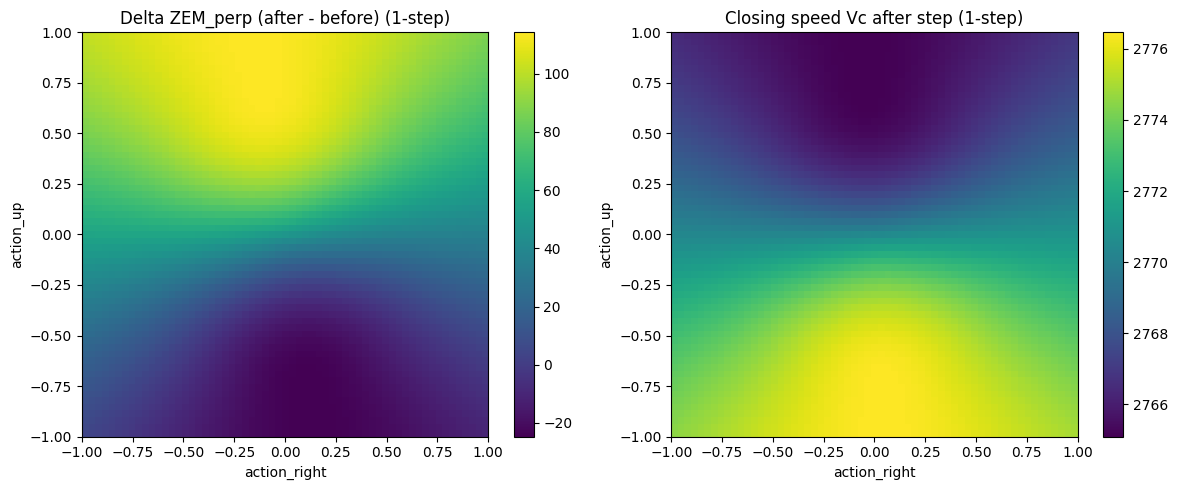

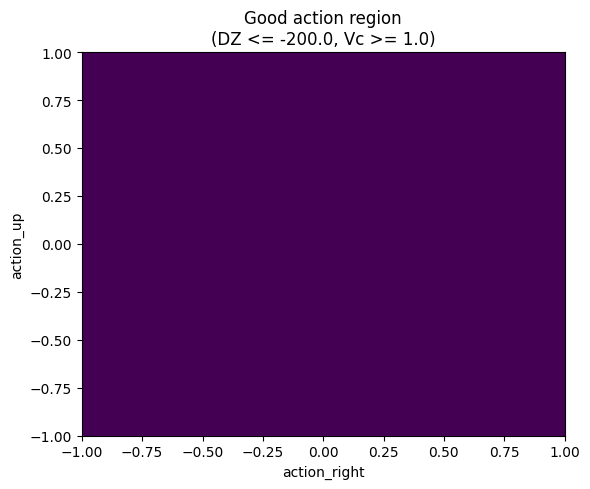

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def state_metrics(env):
    """Return the key signals you care about at the CURRENT env state."""
    phi, zem_perp, Vc, tgo = env._phi_zem_perp()
    dist = float(np.linalg.norm(env.enemy_pos - env.defense_pos))
    return {
        "phi": float(phi),
        "zem_perp": float(zem_perp),
        "Vc": float(Vc),
        "tgo": float(tgo),
        "dist": dist,
    }

def rollout_with_action(env, action, steps=1):
    """
    Roll out `steps` env.step(action) starting from current state.
    Returns last info + last metrics. Stops early if terminated/truncated.
    """
    info_last = None
    terminated = truncated = False
    for _ in range(steps):
        _, _, terminated, truncated, info_last = env.step(action)
        if terminated or truncated:
            break
    m = state_metrics(env) if not (terminated or truncated) else None
    return terminated, truncated, info_last, m

def scan_action_grid(env, grid_n=61, rollout_steps=1, seed=0):
    """
    Freeze env at a single state, scan a grid of actions, and record:
      - delta_zem_perp (negative is good: ZEM_perp decreases)
      - Vc_after (positive is good)
      - event (if terminated)
    """
    # Pick a reproducible state
    env.reset(seed=seed)
    snap0 = env._snapshot()
    m0 = state_metrics(env)
    zem0 = m0["zem_perp"]
    Vc0  = m0["Vc"]

    xs = np.linspace(-1.0, 1.0, grid_n)
    ys = np.linspace(-1.0, 1.0, grid_n)

    delta_zem = np.full((grid_n, grid_n), np.nan, dtype=np.float64)
    Vc_after  = np.full((grid_n, grid_n), np.nan, dtype=np.float64)
    terminated_mask = np.zeros((grid_n, grid_n), dtype=bool)
    event_grid = np.empty((grid_n, grid_n), dtype=object)

    for iy, ay in enumerate(ys):
        for ix, ax in enumerate(xs):
            env._restore(snap0)

            action = np.array([ax, ay], dtype=np.float32)

            term, trunc, info_last, m_after = rollout_with_action(
                env, action, steps=rollout_steps
            )

            if term or trunc:
                terminated_mask[iy, ix] = True
                event_grid[iy, ix] = info_last["event"] if info_last else "terminated"
                continue

            zem1 = m_after["zem_perp"]
            Vc1  = m_after["Vc"]

            delta_zem[iy, ix] = zem1 - zem0     # negative => improved
            Vc_after[iy, ix]  = Vc1
            event_grid[iy, ix] = "running"

    out = {
        "xs": xs, "ys": ys,
        "zem0": zem0, "Vc0": Vc0,
        "delta_zem": delta_zem,
        "Vc_after": Vc_after,
        "terminated_mask": terminated_mask,
        "event_grid": event_grid,
        "m0": m0,
    }
    return out

def plot_action_landscape(scan, title_suffix=""):
    xs, ys = scan["xs"], scan["ys"]
    DZ = scan["delta_zem"]
    VC = scan["Vc_after"]
    term = scan["terminated_mask"]

    # Mask terminated for plotting
    DZ_plot = np.ma.array(DZ, mask=term | np.isnan(DZ))
    VC_plot = np.ma.array(VC, mask=term | np.isnan(VC))

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    im0 = ax[0].imshow(
        DZ_plot, origin="lower",
        extent=[xs.min(), xs.max(), ys.min(), ys.max()],
        aspect="auto"
    )
    ax[0].set_title(f"Delta ZEM_perp (after - before){title_suffix}")
    ax[0].set_xlabel("action_right")
    ax[0].set_ylabel("action_up")
    plt.colorbar(im0, ax=ax[0])

    im1 = ax[1].imshow(
        VC_plot, origin="lower",
        extent=[xs.min(), xs.max(), ys.min(), ys.max()],
        aspect="auto"
    )
    ax[1].set_title(f"Closing speed Vc after step{title_suffix}")
    ax[1].set_xlabel("action_right")
    ax[1].set_ylabel("action_up")
    plt.colorbar(im1, ax=ax[1])

    plt.tight_layout()
    plt.show()

def plot_good_region(scan, zem_improve_thresh=-50.0, vc_min=1.0, title_suffix=""):
    """
    Show a binary mask: "good" actions are those that:
      - reduce ZEM_perp by at least zem_improve_thresh (negative threshold)
      - and have Vc_after >= vc_min
    """
    xs, ys = scan["xs"], scan["ys"]
    DZ = scan["delta_zem"]
    VC = scan["Vc_after"]
    term = scan["terminated_mask"]

    good = (~term) & np.isfinite(DZ) & np.isfinite(VC) & (DZ <= zem_improve_thresh) & (VC >= vc_min)

    plt.figure(figsize=(6, 5))
    plt.imshow(
        good.astype(float), origin="lower",
        extent=[xs.min(), xs.max(), ys.min(), ys.max()],
        aspect="auto"
    )
    plt.title(f"Good action region{title_suffix}\n(DZ <= {zem_improve_thresh}, Vc >= {vc_min})")
    plt.xlabel("action_right")
    plt.ylabel("action_up")
    plt.tight_layout()
    plt.show()

env = missile_interception_3d()
scan = scan_action_grid(env, grid_n=61, rollout_steps=1, seed=0)
plot_action_landscape(scan, title_suffix=" (1-step)")
plot_good_region(scan, zem_improve_thresh=-200.0, vc_min=1.0)


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def scan_action_grid_from_current_state(env, grid_n=61, rollout_steps=1):
    """
    Same as your scan_action_grid, but it does NOT reset.
    It scans from whatever state env is currently in.
    """
    snap0 = env._snapshot()
    m0 = state_metrics(env)
    zem0 = m0["zem_perp"]

    xs = np.linspace(-1.0, 1.0, grid_n)
    ys = np.linspace(-1.0, 1.0, grid_n)

    delta_zem = np.full((grid_n, grid_n), np.nan, dtype=np.float64)
    Vc_after  = np.full((grid_n, grid_n), np.nan, dtype=np.float64)
    terminated_mask = np.zeros((grid_n, grid_n), dtype=bool)

    for iy, ay in enumerate(ys):
        for ix, ax in enumerate(xs):
            env._restore(snap0)
            action = np.array([ax, ay], dtype=np.float32)

            term, trunc, info_last, m_after = rollout_with_action(env, action, steps=rollout_steps)

            if term or trunc or m_after is None:
                terminated_mask[iy, ix] = True
                continue

            zem1 = m_after["zem_perp"]
            Vc1  = m_after["Vc"]
            delta_zem[iy, ix] = zem1 - zem0     # negative => improved
            Vc_after[iy, ix]  = Vc1

    return {
        "xs": xs, "ys": ys,
        "m0": m0,
        "delta_zem": delta_zem,
        "Vc_after": Vc_after,
        "terminated_mask": terminated_mask,
    }

def good_mask(scan, zem_improve_thresh, vc_min=1.0):
    DZ = scan["delta_zem"]
    VC = scan["Vc_after"]
    term = scan["terminated_mask"]
    return (~term) & np.isfinite(DZ) & np.isfinite(VC) & (DZ <= zem_improve_thresh) & (VC >= vc_min)

def good_fraction(scan, zem_improve_thresh, vc_min=1.0):
    gm = good_mask(scan, zem_improve_thresh, vc_min)
    return float(gm.mean())

def run_battery(env,
                seeds=(0,1,2,3,4),
                pre_steps_list=(0, 20, 60, 120),
                warmup_policy="zero",
                grid_n=61,
                rollout_steps=5,
                vc_min=1.0,
                zem_improve_frac=0.002):
    """
    For each seed and each timepoint (pre_steps), we:
      - reset(seed)
      - roll pre_steps using warmup_policy (zero or pronav)
      - scan action grid from that state
      - compute good fraction

    zem_improve_thresh is scaled per-state as: - zem_improve_frac * zem0
    (so threshold adapts to scale of the engagement).
    """
    results = []
    examples = []  # store a few scans to plot

    for seed in seeds:
        obs, _ = env.reset(seed=seed)
        done = False

        for pre_steps in pre_steps_list:
            # re-reset each timepoint so it's deterministic
            obs, _ = env.reset(seed=seed)
            done = False

            for _ in range(pre_steps):
                if warmup_policy == "pronav":
                    a = env.calculate_pronav()
                else:
                    a = np.array([0.0, 0.0], dtype=np.float32)

                obs, _, term, trunc, info = env.step(a)
                if term or trunc:
                    done = True
                    break

            if done:
                results.append({
                    "seed": seed, "pre_steps": pre_steps,
                    "status": "terminated_before_scan",
                    "event": info.get("event", "unknown"),
                })
                continue

            scan = scan_action_grid_from_current_state(env, grid_n=grid_n, rollout_steps=rollout_steps)

            zem0 = scan["m0"]["zem_perp"]
            zem_thresh = -zem_improve_frac * zem0   # adaptive threshold
            frac = good_fraction(scan, zem_thresh, vc_min=vc_min)

            results.append({
                "seed": seed,
                "pre_steps": pre_steps,
                "status": "ok",
                "zem0": float(zem0),
                "Vc0": float(scan["m0"]["Vc"]),
                "zem_thresh": float(zem_thresh),
                "good_frac": float(frac),
            })

            # keep a couple of scans for visualization
            if len(examples) < 6:
                examples.append((seed, pre_steps, scan, zem_thresh))

    return results, examples

def plot_good_region_with_thresh(scan, zem_thresh, vc_min=1.0, title=""):
    xs, ys = scan["xs"], scan["ys"]
    gm = good_mask(scan, zem_thresh, vc_min)

    plt.figure(figsize=(6, 5))
    plt.imshow(gm.astype(float), origin="lower",
               extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               aspect="auto")
    plt.title(title + f"\nDZ <= {zem_thresh:.2f}, Vc >= {vc_min}")
    plt.xlabel("action_right")
    plt.ylabel("action_up")
    plt.tight_layout()
    plt.show()

def summarize_results(results):
    good_fracs = [r["good_frac"] for r in results if r.get("status") == "ok"]
    if not good_fracs:
        print("No successful scans.")
        return
    print(f"Scans: {len(good_fracs)}")
    print(f"Good fraction mean: {np.mean(good_fracs):.4f}")
    print(f"Good fraction p50 : {np.median(good_fracs):.4f}")
    print(f"Good fraction p10 : {np.percentile(good_fracs, 10):.4f}")
    print(f"Good fraction p90 : {np.percentile(good_fracs, 90):.4f}")

    plt.figure(figsize=(6,4))
    plt.hist(good_fracs, bins=20)
    plt.title("Distribution of good action fraction across scanned states")
    plt.xlabel("good_frac")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# Example usage:
# env = missile_interception_3d()
# results, examples = run_battery(
#     env,
#     seeds=range(20),              # 20 random initial conditions
#     pre_steps_list=(0, 20, 60, 120),
#     warmup_policy="zero",         # or "pronav"
#     grid_n=51,
#     rollout_steps=5,              # 5 steps = 0.5 seconds (since dt_act=0.1)
#     vc_min=1.0,
#     zem_improve_frac=0.002        # require 0.2% ZEM_perp reduction over the rollout
# )
# summarize_results(results)
# for (seed, pre_steps, scan, zem_thresh) in examples:
#     plot_good_region_with_thresh(
#         scan, zem_thresh, vc_min=1.0,
#         title=f"seed={seed}, pre_steps={pre_steps}, zem0={scan['m0']['zem_perp']:.1f}, Vc0={scan['m0']['Vc']:.1f}"
#     )

Scans: 80
Good fraction mean: 0.2877
Good fraction p50 : 0.3206
Good fraction p10 : 0.1206
Good fraction p90 : 0.3982


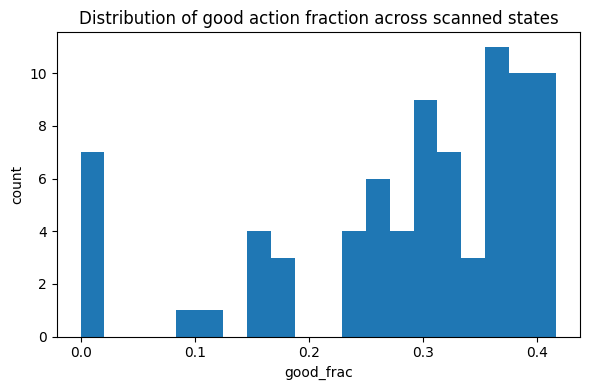

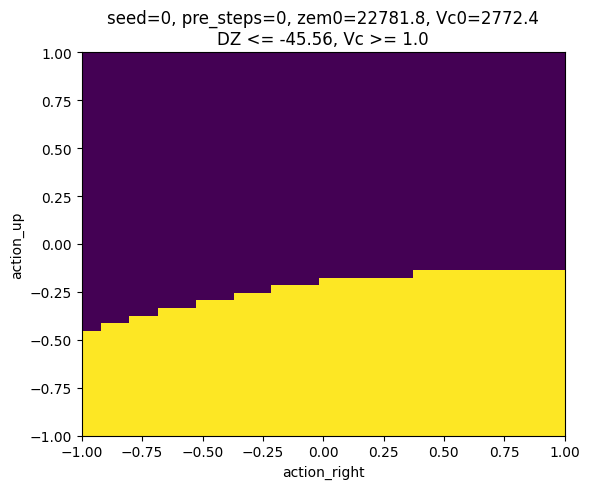

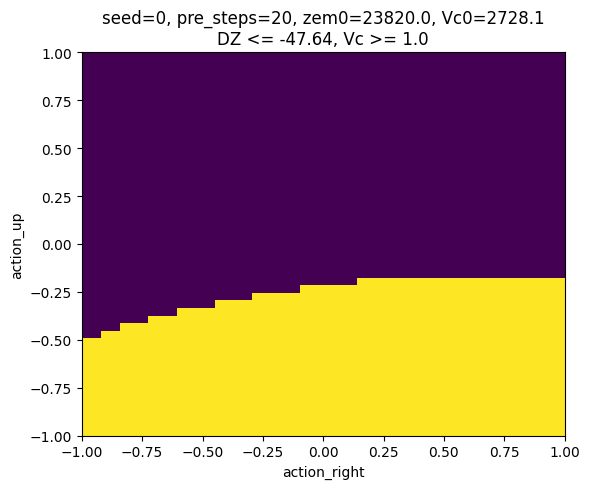

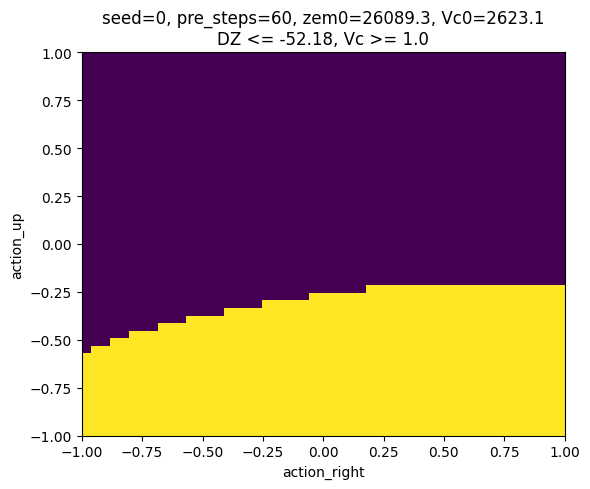

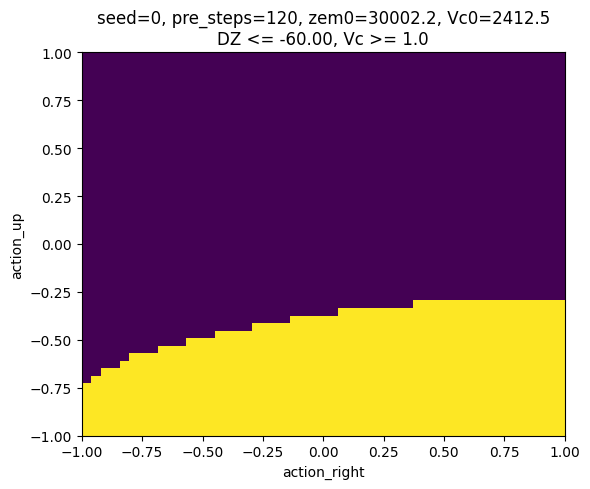

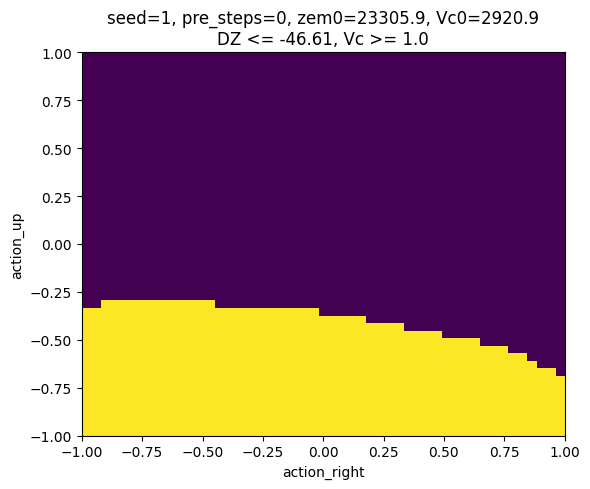

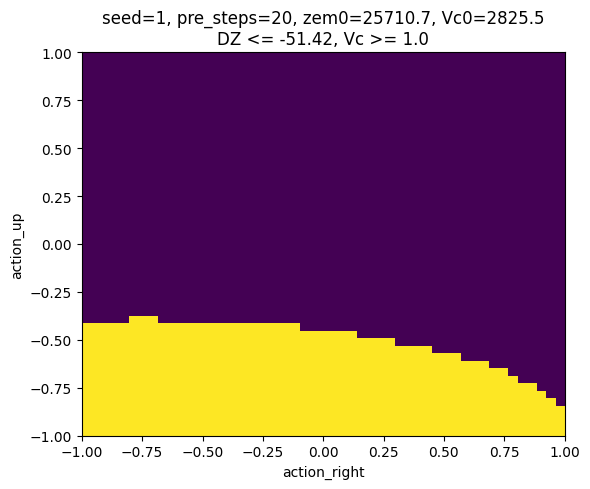

In [4]:
# Run the comprehensive battery test
env = missile_interception_3d()

results, examples = run_battery(
    env,
    seeds=range(20),              # 20 random initial conditions
    pre_steps_list=(0, 20, 60, 120),
    warmup_policy="zero",         # or "pronav"
    grid_n=51,
    rollout_steps=5,              # 5 steps = 0.5 seconds (since dt_act=0.1)
    vc_min=1.0,
    zem_improve_frac=0.002        # require 0.2% ZEM_perp reduction over the rollout
)

summarize_results(results)

# Plot example scans
for (seed, pre_steps, scan, zem_thresh) in examples:
    plot_good_region_with_thresh(
        scan, zem_thresh, vc_min=1.0,
        title=f"seed={seed}, pre_steps={pre_steps}, zem0={scan['m0']['zem_perp']:.1f}, Vc0={scan['m0']['Vc']:.1f}"
    )


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def _action_sample_gaussian(n, sigma, rng):
    """
    Sample actions ~ N(0, sigma^2 I), clip to [-1,1], then mimic env:
      if ||a|| > 1 => normalize to unit norm.
    """
    a = rng.normal(loc=0.0, scale=sigma, size=(n, 2)).astype(np.float32)
    a = np.clip(a, -1.0, 1.0)

    mags = np.linalg.norm(a, axis=1, keepdims=True)  # (n,1)
    mask = mags[:, 0] > 1.0                          # (n,)
    if np.any(mask):
        a[mask] = a[mask] / mags[mask]               # (k,2)/(k,1) works
    return a
def mc_good_prob_for_state(env, snap0, zem0, n_samples=2000, sigma=0.3, rollout_steps=1, vc_min=0.0):
    rng = np.random.default_rng(0)
    actions = _action_sample_gaussian(n_samples, sigma, rng)

    good = 0
    closing = 0
    improved = 0
    term = 0

    for i in range(n_samples):
        env._restore(snap0)
        a = actions[i]
        terminated = truncated = False
        info_last = None
        for _ in range(rollout_steps):
            _, _, terminated, truncated, info_last = env.step(a)
            if terminated or truncated:
                break
        if terminated or truncated:
            term += 1
            continue

        # compute post metrics
        phi, zem1, Vc1, tgo = env._phi_zem_perp()
        dz = zem1 - zem0  # negative good

        if Vc1 > vc_min:
            closing += 1
        if dz < 0.0:
            improved += 1
        if (Vc1 > vc_min) and (dz < 0.0):
            good += 1

    denom = n_samples - term if (n_samples - term) > 0 else 1
    return {
        "p_good": good / denom,
        "p_closing": closing / denom,
        "p_improve": improved / denom,
        "term_frac": term / n_samples,
        "n_eff": denom
    }

def mc_over_many_states(env, seeds=40, pre_steps_list=(0, 20, 60), n_samples=2000, sigma=0.3, rollout_steps=1, vc_min=0.0, progress_every=5):
    results = []
    total_jobs = seeds * len(pre_steps_list)
    job = 0

    for s in range(seeds):
        for pre in pre_steps_list:
            job += 1
            env.reset(seed=s)
            # advance to a later time in episode (zero action)
            for _ in range(pre):
                env.step(np.array([0.0, 0.0], dtype=np.float32))
                if getattr(env, "done", False):
                    break
            if getattr(env, "done", False):
                # skip terminal states
                continue

            snap0 = env._snapshot()
            phi0, zem0, Vc0, tgo0 = env._phi_zem_perp()

            stats = mc_good_prob_for_state(
                env, snap0, zem0,
                n_samples=n_samples,
                sigma=sigma,
                rollout_steps=rollout_steps,
                vc_min=vc_min
            )
            stats.update({"seed": s, "pre_steps": pre, "zem0": zem0, "Vc0": Vc0})
            results.append(stats)

            if job % progress_every == 0 or job == total_jobs:
                # running summary
                pg = np.array([r["p_good"] for r in results], dtype=float)
                pc = np.array([r["p_closing"] for r in results], dtype=float)
                pi = np.array([r["p_improve"] for r in results], dtype=float)
                tf = np.array([r["term_frac"] for r in results], dtype=float)
                print(f"[{job:03d}/{total_jobs}] sigma={sigma} rollout_steps={rollout_steps} | "
                      f"p_good mean={pg.mean():.3f} p50={np.median(pg):.3f} p10={np.percentile(pg,10):.3f} p90={np.percentile(pg,90):.3f} | "
                      f"p_closing mean={pc.mean():.3f} | p_improve mean={pi.mean():.3f} | term mean={tf.mean():.3f}")
    return results

# NOTE: This assumes missile_interception_3d is defined in the user's runtime.
# If it isn't, this won't run here. We only provide code + structure.
print("Monte Carlo helpers defined. Use:\n"
      "env = missile_interception_3d()\n"
      "results = mc_over_many_states(env, seeds=80, pre_steps_list=(0,20,60), n_samples=3000, sigma=0.3, rollout_steps=1)\n"
      "Try sigma in {0.1,0.2,0.3,0.5} and rollout_steps in {1,5,10}.")

env = missile_interception_3d()

results = mc_over_many_states(
    env,
    seeds=80,
    pre_steps_list=(0, 20, 60),   # sample early/mid/late-ish states
    n_samples=3000,               # MC samples per state
    sigma=0.3,                    # “PPO-ish” exploration width
    rollout_steps=1,              # 1-step test; try 5 or 10 too
    vc_min=0.0,                   # closing test: Vc > 0
    progress_every=5              # prints progress
)


Monte Carlo helpers defined. Use:
env = missile_interception_3d()
results = mc_over_many_states(env, seeds=80, pre_steps_list=(0,20,60), n_samples=3000, sigma=0.3, rollout_steps=1)
Try sigma in {0.1,0.2,0.3,0.5} and rollout_steps in {1,5,10}.
[005/240] sigma=0.3 rollout_steps=1 | p_good mean=0.046 p50=0.015 p10=0.000 p90=0.113 | p_closing mean=1.000 | p_improve mean=0.046 | term mean=0.000
[010/240] sigma=0.3 rollout_steps=1 | p_good mean=0.062 p50=0.007 p10=0.000 p90=0.163 | p_closing mean=1.000 | p_improve mean=0.062 | term mean=0.000
[015/240] sigma=0.3 rollout_steps=1 | p_good mean=0.084 p50=0.000 p10=0.000 p90=0.321 | p_closing mean=1.000 | p_improve mean=0.084 | term mean=0.000
[020/240] sigma=0.3 rollout_steps=1 | p_good mean=0.090 p50=0.041 p10=0.000 p90=0.308 | p_closing mean=1.000 | p_improve mean=0.090 | term mean=0.000
[025/240] sigma=0.3 rollout_steps=1 | p_good mean=0.087 p50=0.050 p10=0.000 p90=0.257 | p_closing mean=1.000 | p_improve mean=0.087 | term mean=0.000
[030/24